In [1]:
import gseapy as gp
import pandas as pd
import numpy as np
import scipy

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

import re
from gseapy import Biomart

import matplotlib.pyplot as plt
import seaborn as sns
from scripts import aesthetics

aesthetics.activate_paper_rcParams()

# CWAS Gene Set Enrichment

In this notebook, we explore whether categories significantly enriched for SVs in cases vs. controls reflect any higher level biological process. One way to do this is with gene set enrichment.

# What is gene set enrichment anyway?

The idea of gene set enrichment is that in a list of genes (i.e. upregulated genes, or genes targeted by a "category"), if it were random, would have a certain degree of overlap with a gene set by pure chance. The idea of gene set enrichment is that we determine overlap with a gene set, and compare this to the background.

This is a bit weirder with these data, since we have actual _SV counts_. The underlying test for gene set enrichment is a fisher's exact test, which does work with counts, but it assumes independence between individual counts. Furthermore, the vast majority of gene set enrichment tools do not allow multiple counts of the same gene.

This means that we need to do this somewhat manually.

# Load in the data

We load in the SVs and dosages, which we'll need.

## Read in SVs

In [34]:
# define SVs and dosages for discovery and validation
sv_path = "gs://vanallen-pedsv-analysis/beds/PedSV.v2.5.2.full_cohort.analysis_samples.sites.bed.gz"
dosages_path = "gs://vanallen-pedsv-analysis/beds/PedSV.v2.5.2.full_cohort.analysis_samples.allele_dosages.bed.gz"

# define metadata
metadata_path = "gs://vanallen-pedsv-analysis/sample_info/PedSV.v2.5.2.cohort_metadata.w_control_assignments.tsv.gz"
samples_path = "gs://vanallen-pedsv-analysis/sample_info/PedSV.v2.5.2.final_analysis_cohort.samples.list"

# list of genes that are annotated - drop ensembl IDs
gene_ref = pd.read_csv("ref/gencode_hg38_protein_coding_genes_for_annotation_7_31_23.txt")
gene_ref = gene_ref[~gene_ref['value'].str.startswith('ENSG00')]
gene_ref = gene_ref['value'].tolist()

Load metadata and SVs

In [35]:
metadata = pd.read_csv(
    metadata_path,
    sep="\t",
)

# add a sex label to metadata
metadata["sex"] = (metadata["chrX_CopyNumber"].round() < 2).astype(int)

###############
### Samples ###
###############
nbl_cases = metadata[
    (metadata["neuroblastoma_case"] == True)
]["entity:sample_id"].tolist()

nbl_controls = metadata[
    (metadata["neuroblastoma_control"] == True)
]["entity:sample_id"].tolist()

len(nbl_cases), len(nbl_controls)

(688, 4830)

Now we load the SVs. We'll eventually combine discovery and validation data, but it's easiest to keep them separate for now, since the SVs and dosages are not fully overlapping.

In [4]:
###############
##### SVs #####
###############
svs = pd.read_csv(
    sv_path,
    sep="\t",
)

###############
### Dosages ###
###############
dosages = pd.read_csv(
    dosages_path,
    sep="\t",
    index_col=False,
)

/Users/jettcrowdis/opt/anaconda3/envs/pediatric-germline-svs-3.7.13/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (34,35,37,39,41,45,46,47,48,72,73,87,88,106,107,121,122,136,137,155,156,170,171,185,186,204,205,219,220,234,235,253,254,268,269,283,284,302,303,366,367,381,382,400,401,415,416,430,431,449,450,464,465,479,480,498,499,513,514,528,529,547,548,562,563,577,578,596,597,645,646,647,648,649,650,690,691,692,693,694,695,713,714,728,729,743,744,758,759,773,774,788,789,803,804,818,819,833,834,848,849,863,864,878,879,893,894,908,909,923,924,931,937,943) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


## Read in the category results

I'm going to concatenate all this data so that I'm only dealing with a few files. Focusing on neuroblastoma.

In [36]:
###########
### SVs ###
###########
nbl_coding_svs = pd.read_csv(
    "data/CWAS data for Jett/List of variants by category for each CWAS analysis/neuroblastoma_all_coding_SVs_in_each_category_list_combined_11_3_23.txt",
    sep="\t",
)

nbl_noncoding_svs = pd.read_csv('data/CWAS data for Jett/List of variants by category for each CWAS analysis/neuroblastoma_all_noncoding_SVs_in_each_category_list_combined_BURDEN_TESTING_with_col_names_11_3_23.txt', sep='\t')
nbl_noncoding_svs = nbl_noncoding_svs.rename(columns = {'emd': 'end'})

# combine the SVs
nbl_coding_svs['sv_category'] = 'coding'
nbl_noncoding_svs['sv_category'] = 'non-coding'

nbl_category_svs = pd.concat([nbl_coding_svs, nbl_noncoding_svs])
nbl_category_svs.head(2)

,SV,chrom,start,end,category,sv_category
0,PedSV.2.5.2_DUP_chr1_794,chr1,19221626,19301822,DUP.RARE.PREDICTED_COPY_GAIN.lof_constrained.e...,coding
1,PedSV.2.5.2_DUP_chr1_1379,chr1,44731601,44792024,DUP.RARE.PREDICTED_COPY_GAIN.lof_constrained.e...,coding


In [37]:
#########################
### FRAMEWORK RESULTS ###
#########################
nbl_singleton_coding_framework_results = pd.read_csv(
    "data/CWAS data for Jett/CWAS sum stats/neuroblastoma_all_coding_cwas_concatenated_glm_results_SINGLETON_11_3_23.txt",
    sep="\t",
)
nbl_singleton_coding_framework_results[['af_category', 'sv_category']] = ['singleton', 'coding']

nbl_rare_coding_framework_results = pd.read_csv(
    "data/CWAS data for Jett/CWAS sum stats/neuroblastoma_all_coding_cwas_concatenated_glm_results_RARE_11_3_23.txt",
    sep="\t",
)
nbl_rare_coding_framework_results[['af_category', 'sv_category']] = ['rare', 'coding']

nbl_singleton_noncoding_framework_results = pd.read_csv(
    "data/CWAS data for Jett/CWAS sum stats/neuroblastoma_all_noncoding_cwas_concatenated_glm_results_SINGLETON_11_3_23.txt",
    sep="\t",
)
nbl_singleton_noncoding_framework_results[['af_category', 'sv_category']] = ['singleton', 'non-coding']

nbl_rare_noncoding_framework_results = pd.read_csv(
    "data/CWAS data for Jett/CWAS sum stats/neuroblastoma_all_noncoding_cwas_concatenated_glm_results_RARE_11_3_23.txt",
    sep="\t",
)
nbl_rare_noncoding_framework_results[['af_category', 'sv_category']] = ['rare', 'non-coding']

nbl_framework_results = pd.concat([nbl_singleton_coding_framework_results, nbl_rare_coding_framework_results, 
                                   nbl_singleton_noncoding_framework_results, nbl_rare_noncoding_framework_results])

In [38]:
nbl_framework_results.head(2)

,point_estimate,std_error,z_score,p_value,SV_counts_cases,SV_counts_cases_max,number_of_cases_with_zero_SVs,total_cases,SV_counts_controls,SV_counts_controls_max,number_of_controls_with_zero_SVs,total_controls,number_of_unique_SVs,category_name,sv_type,frequency,mean_SVs_per_case,mean_SVs_per_control,mean_SVs_total,negative_log10_p_value,af_category,sv_category
0,0.271918,0.051227,5.308100,1.110000e-07,438,5,336,646,2441,4,2848,4700,459,ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTI...,ANY,SINGLETON,0.678019,0.519362,0.538533,6.955563,singleton,coding
1,0.276065,0.054006,5.111756,3.190000e-07,393,5,356,646,2172,4,3012,4700,411,DEL.SINGLETON.ANY.ANY.ANY.protein_coding,DEL,SINGLETON,0.608359,0.462128,0.479798,6.495968,singleton,coding


In [39]:
nbl_coding_framework = pd.read_csv(
    "data/CWAS data for Jett/CWAS frameworks/CWAS_categories_neuroblastoma_coding_8_17_23.txt",
    sep="\t",
)

nbl_noncoding_framework = pd.read_csv(
    "data/CWAS data for Jett/CWAS frameworks/CWAS_rare_categories_neuroblastoma_noncoding_10_2_23.txt",
    sep="\t",
)

In [40]:
nbl_noncoding_framework

,sv_type,frequency,functional_intersection,functional_category,genic_relationship,constraint,expression,gene_group
0,DUP,RARE,PREDICTED_NONCODING_BREAKPOINT,neuroblastoma_atac_peaks,PREDICTED_INTERGENIC,lof_constrained,expressed_in_adrenal_gland,protein_coding
1,DEL,SINGLETON,PREDICTED_NONCODING_SPAN,neuroblastoma_chromHMM15_Enh,PREDICTED_INTRONIC,ANY,ANY,cosmic_and_germline_CPGs
2,CPX_or_INV,NaN,ANY,neuroblastoma_chromHMM15_Enh_conserved,PREDICTED_PROMOTER,NaN,NaN,NaN
3,INS_ALL,NaN,NaN,neuroblastoma_chromHMM15_EnhG,PREDICTED_UTR,NaN,NaN,NaN
4,ANY,NaN,NaN,neuroblastoma_chromHMM15_EnhG_conserved,ANY,NaN,NaN,NaN
5,NaN,NaN,NaN,neuroblastoma_H3K27Ac_peak,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,neuroblastoma_chromHMM15_TssAFlnk,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,neuroblastoma_ABC_MAX_enhancer,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,neuroblastoma_atac_peaks_conserved,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,neuroblastoma_chromHMM15_EnhBiv,NaN,NaN,NaN,NaN


# Walk through some examples

## A coding example

Let's extract out all the data that we need to examine the highest result for a single hallmark gene set.

In [41]:
test_framework = nbl_framework_results.query('af_category == "singleton" & sv_category == "coding"').loc[0, ["category_name"]].item()
framework_components = test_framework.split(".")
genic_relationship = framework_components[2]
test_framework, genic_relationship

('ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.ANY.ANY.protein_coding',
 'PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP')

In [42]:
nbl_coding_framework.head(5)

,sv_type,frequency,genic_relationship,constraint,expression,gene_group
0,DUP,RARE,PREDICTED_COPY_GAIN,lof_constrained,expressed_in_adrenal_gland,protein_coding
1,DEL,SINGLETON,PREDICTED_INTRAGENIC_EXON_DUP,missense_constrained,ANY,cosmic_cancer_genes
2,CPX_or_INV,NaN,PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP,unconstrained,NaN,germline_CPGs
3,INS_ALL,NaN,ANY,ANY,NaN,base_excision_repair_genes
4,ANY,NaN,NaN,NaN,NaN,chromatin_organization_genes


We identify the SVs that are part of that category.

In [43]:
svs_in_category = nbl_category_svs[(nbl_category_svs['sv_category'] == "coding") & 
                                   (nbl_category_svs["category"] == test_framework)]

# subset the actual SV matrix
svs_in_category = svs[svs["name"].isin(svs_in_category["SV"].tolist())]

svs_in_category.head(2)

,#chrom,start,end,name,svtype,AC,AF,ALGORITHMS,AN,BOTHSIDES_SUPPORT,CHR2,CNV_CONCORDANCE,CPX_INTERVALS,CPX_TYPE,END,END2,EVIDENCE,FAILED_COHORT_COMPARISONS,GENOTYPE_CONCORDANCE,HET_PPV,HET_SENSITIVITY,HG38_REF_PATCH_LOCUS,HIGH_SR_BACKGROUND,HOMVAR_PPV,HOMVAR_SENSITIVITY,MINSL,NCN,NCR,NCR_TMP,NON_REF_GENOTYPE_CONCORDANCE,OLD_ID,PCRMINUS_NCR,PESR_GT_OVERDISPERSION,PREDICTED_BREAKEND_EXONIC,PREDICTED_COPY_GAIN,PREDICTED_DUP_PARTIAL,PREDICTED_INTERGENIC,PREDICTED_INTRAGENIC_EXON_DUP,PREDICTED_INTRONIC,PREDICTED_INV_SPAN,PREDICTED_LOF,PREDICTED_MSV_EXON_OVERLAP,PREDICTED_NEAREST_TSS,PREDICTED_NONCODING_BREAKPOINT,PREDICTED_NONCODING_SPAN,PREDICTED_PARTIAL_EXON_DUP,PREDICTED_PROMOTER,PREDICTED_TSS_DUP,PREDICTED_UTR,SL_MAX,SL_MEAN,SOURCE,STATUS,STRANDS,SVLEN,SVTYPE,TRUTH_AC,TRUTH_AF,TRUTH_AN,TRUTH_VID,UNRESOLVED_TYPE,VAR_PPV,VAR_SENSITIVITY,VAR_SPECIFICITY,N_BI_GENOS,N_HOMREF,N_HET,N_HOMALT,FREQ_HOMREF,FREQ_HET,FREQ_HOMALT,CN_NUMBER,CN_COUNT,CN_FREQ,CN_NONREF_COUNT,CN_NONREF_FREQ,MALE_AN,MALE_AC,MALE_AF,MALE_N_BI_GENOS,MALE_N_HOMREF,MALE_N_HET,MALE_N_HOMALT,MALE_FREQ_HOMREF,MALE_FREQ_HET,MALE_FREQ_HOMALT,MALE_CN_NUMBER,MALE_CN_COUNT,MALE_CN_FREQ,MALE_CN_NONREF_COUNT,MALE_CN_NONREF_FREQ,MALE_N_HEMIREF,MALE_N_HEMIALT,MALE_FREQ_HEMIREF,MALE_FREQ_HEMIALT,FEMALE_AN,FEMALE_AC,FEMALE_AF,FEMALE_N_BI_GENOS,FEMALE_N_HOMREF,FEMALE_N_HET,FEMALE_N_HOMALT,FEMALE_FREQ_HOMREF,FEMALE_FREQ_HET,FEMALE_FREQ_HOMALT,FEMALE_CN_NUMBER,FEMALE_CN_COUNT,FEMALE_CN_FREQ,FEMALE_CN_NONREF_COUNT,FEMALE_CN_NONREF_FREQ,case_control_AFR_AN,case_control_AFR_AC,case_control_AFR_AF,case_control_AFR_N_BI_GENOS,case_control_AFR_N_HOMREF,case_control_AFR_N_HET,case_control_AFR_N_HOMALT,case_control_AFR_FREQ_HOMREF,case_control_AFR_FREQ_HET,case_control_AFR_FREQ_HOMALT,case_control_AFR_CN_NUMBER,case_control_AFR_CN_COUNT,case_control_AFR_CN_FREQ,case_control_AFR_CN_NONREF_COUNT,case_control_AFR_CN_NONREF_FREQ,case_control_AFR_MALE_AN,case_control_AFR_MALE_AC,case_control_AFR_MALE_AF,case_control_AFR_MALE_N_BI_GENOS,case_control_AFR_MALE_N_HOMREF,case_control_AFR_MALE_N_HET,case_control_AFR_MALE_N_HOMALT,case_control_AFR_MALE_FREQ_HOMREF,case_control_AFR_MALE_FREQ_HET,case_control_AFR_MALE_FREQ_HOMALT,case_control_AFR_MALE_CN_NUMBER,case_control_AFR_MALE_CN_COUNT,case_control_AFR_MALE_CN_FREQ,case_control_AFR_MALE_CN_NONREF_COUNT,case_control_AFR_MALE_CN_NONREF_FREQ,case_control_AFR_MALE_N_HEMIREF,case_control_AFR_MALE_N_HEMIALT,case_control_AFR_MALE_FREQ_HEMIREF,case_control_AFR_MALE_FREQ_HEMIALT,case_control_AFR_FEMALE_AN,case_control_AFR_FEMALE_AC,case_control_AFR_FEMALE_AF,case_control_AFR_FEMALE_N_BI_GENOS,case_control_AFR_FEMALE_N_HOMREF,case_control_AFR_FEMALE_N_HET,case_control_AFR_FEMALE_N_HOMALT,case_control_AFR_FEMALE_FREQ_HOMREF,case_control_AFR_FEMALE_FREQ_HET,case_control_AFR_FEMALE_FREQ_HOMALT,case_control_AFR_FEMALE_CN_NUMBER,case_control_AFR_FEMALE_CN_COUNT,case_control_AFR_FEMALE_CN_FREQ,case_control_AFR_FEMALE_CN_NONREF_COUNT,case_control_AFR_FEMALE_CN_NONREF_FREQ,case_control_AMR_AN,case_control_AMR_AC,case_control_AMR_AF,case_control_AMR_N_BI_GENOS,case_control_AMR_N_HOMREF,case_control_AMR_N_HET,case_control_AMR_N_HOMALT,case_control_AMR_FREQ_HOMREF,case_control_AMR_FREQ_HET,case_control_AMR_FREQ_HOMALT,case_control_AMR_CN_NUMBER,case_control_AMR_CN_COUNT,case_control_AMR_CN_FREQ,case_control_AMR_CN_NONREF_COUNT,case_control_AMR_CN_NONREF_FREQ,case_control_AMR_MALE_AN,case_control_AMR_MALE_AC,case_control_AMR_MALE_AF,case_control_AMR_MALE_N_BI_GENOS,case_control_AMR_MALE_N_HOMREF,case_control_AMR_MALE_N_HET,case_control_AMR_MALE_N_HOMALT,case_control_AMR_MALE_FREQ_HOMREF,case_control_AMR_MALE_FREQ_HET,case_control_AMR_MALE_FREQ_HOMALT,case_control_AMR_MALE_CN_NUMBER,case_control_AMR_MALE_CN_COUNT,case_control_AMR_MALE_CN_FREQ,case_control_AMR_MALE_CN_NONREF_COUNT,case_control_AMR_MALE_CN_NONREF_FREQ,case_control_AMR_MALE_N_HEMIREF,case_control_AMR_MALE_N_HEMIALT,case_control_AMR_MALE_FREQ_HEMIREF,case_control_AMR_MALE_FREQ_HEMIALT,case_control_AMR_FEMALE

In [44]:
svs_in_category.shape

(3833, 952)

Next, we determine the genes in question. We reference the column where the genes can be found, `genic_relationship`. We have to split this one in half.

In [45]:
genic_relationships = genic_relationship.split("_or_")
genic_relationships

['PREDICTED_LOF', 'PREDICTED_PARTIAL_EXON_DUP']

In [46]:
svs_in_category[genic_relationships].head()

,PREDICTED_LOF,PREDICTED_PARTIAL_EXON_DUP
64,SAMD11,NaN
152,C1QTNF12,NaN
162,"ACAP3,INTS11,PUSL1,SCNN1D",NaN
173,CPTP,NaN
198,"TMEM88B,VWA1",NaN


We should be a bit more careful if any results turn up positive, but for now we'll just register an SV as contributing to a count for that gene.

In [47]:
nbl_sv_dosages = (
    dosages
    .set_index("ID")
    .loc[svs_in_category["name"].tolist(), nbl_cases + nbl_controls]
)
nbl_sv_dosages.head(2)

PT_00QYKRAX  PT_00Y8C0XA  PT_025YMME2  PT_02AE4RSP  \
ID                                                                             
PedSV.2.5.2_DEL_chr1_80           0.0          0.0          0.0          0.0   
PedSV.2.5.2_DEL_chr1_210          0.0          0.0          0.0          0.0   

                          PT_02SNWVRF  PT_06Z51EN5  PT_0CKD259J  PT_0GMP9VVY  \
ID                                                                             
PedSV.2.5.2_DEL_chr1_80           NaN          0.0          0.0          NaN   
PedSV.2.5.2_DEL_chr1_210          0.0          0.0          0.0          0.0   

                          PT_0MVMPZKX  PT_11XN6CG5  PT_1396H6SD  PT_1EQHANKW  \
ID                                                                             
PedSV.2.5.2_DEL_chr1_80           0.0          0.0          0.0          0.0   
PedSV.2.5.2_DEL_chr1_210          0.0          0.0          0.0          0.0   

                          PT_1PA8YT1W  PT_1RH3DTPB  PT_1WETGRS9  PT_1X6CJ589  \
ID                                                                             
PedSV.2.5.2_DEL_chr1_80           0.0          0.0          0.0          0.0   
PedSV.2.5.2_DEL_chr1_210          0.0          0.0          0.0          0.0   

                          PT_1X9YQF9W  PT_21PJ8R0Z  PT_26E4RFYV  PT_2E11C89R  \
ID                                                                             
PedSV.2.5.2_DEL_chr1_80           0.0          0.0          NaN          0.0   
PedSV.2.5.2_DEL_chr1_210          0.0          0.0          0.0          0.0   

                          PT_2HW3QVXZ  PT_2JZNQGTR  PT_2QB9MP9J  PT_2RZN4HR2  \
ID                                                                             
PedSV.2.5.2_DEL_chr1_80           0.0          0.0          0.0          0.0   
PedSV.2.5.2_DEL_chr1_210          0.0          0.0          0.0          0.0   

                          PT_2Y7Q85BM  PT_34XXD32F  PT_397V1YW0  PT_39P91GFA  \
ID                                                                             
PedSV.2.5.2_DEL_chr1_80           0.0          0.0          0.0          0.0   
PedSV.2.5.2_DEL_chr1_210          0.0          0.0          0.0          0.0   

                          PT_39TTDEKT  PT_3E2DBRZY  PT_3TE71Z5R  PT_3VNMNFT6  \
ID                                                                             
PedSV.2.5.2_DEL_chr1_80           0.0          NaN          0.0          0.0   
PedSV.2.5.2_DEL_chr1_210          0.0          0.0          0.0          0.0   

                          PT_4AK1B8JE  PT_4RVXKBFW  PT_4XJZ1KCB  PT_4Y3P2N1P  \
ID                                                                             
PedSV.2.5.2_DEL_chr1_80           0.0          0.0          0.0          0.0   
PedSV.2.5.2_DEL_chr1_210          0.0          0.0          0.0          0.0   

                          PT_534V39HR  PT_56ZM694R  PT_571RCJF0  PT_5BJXQ731  \
ID                                                                             
PedSV.2.5.2_DEL_chr1_80           0.0          0.0          0.0          0.0   
PedSV.2.5.2_DEL_chr1_210          0.0          0.0          0.0          0.0   

                          PT_5CZHK9CR  PT_5E269C8Z  PT_5FCYBT0S  PT_5FR1MCKJ  \
ID                                                                             
PedSV.2.5.2_DEL_chr1_80           NaN          0.0          0.0          0.0   
PedSV.2.5.2_DEL_chr1_210          0.0          0.0          0.0          0.0   

                          PT_5FZDWV2R  PT_5GCSG960  PT_5J8N74BF  PT_5V8MX9JF  \
ID                                                                             
PedSV.2.5.2_DEL_chr1_80           0.0          0.0          NaN          0.0   
PedSV.2.5.2_DEL_chr1_210          0.0          0.0          0.0          0.0   

                          PT_5WAKHYY2  PT_5YZ3J8E7  PT_60H7NA5N  PT_611QXG3Z  \
ID                                                                             
PedSV.2.5.2_DE

In [48]:
nbl_sv_dosages.shape

(3833, 5518)

So we now have the dosages for both cases and controls. We analyze these two datasets separately, and will need to determine post-hoc if there is a unique enrichment in cases vs. control. Additionally, we need to drop samples that are poorly genotyped for these SVs. The strategy that Ryan and Riaz used is to drop samples with >5% `NaN` genotyping rate. We do that here.

In [49]:
kept = pd.isnull(nbl_sv_dosages).sum(axis = 0) / len(nbl_sv_dosages) < 0.05

nbl_kept_cases = list(set(nbl_cases) & set(kept[kept].index))
nbl_kept_controls = list(set(nbl_controls) & set(kept[kept].index))

In [50]:
nbl_sv_dosages = nbl_sv_dosages.loc[:, kept]

In [51]:
nbl_sv_dosages.shape

(3833, 5345)

So now we can generate our counts, separately for cases and controls. We can ignore `NaNs`.

In [52]:
sv_counts_cases = nbl_sv_dosages[nbl_kept_cases].fillna(0).sum(axis=1).sort_values()
sv_counts_controls = nbl_sv_dosages[nbl_kept_controls].fillna(0).sum(axis=1).sort_values()
sv_counts_cases.head()

ID
PedSV.2.5.2_DEL_chr1_80       0.0
PedSV.2.5.2_DEL_chr12_7621    0.0
PedSV.2.5.2_DEL_chr12_7627    0.0
PedSV.2.5.2_DEL_chr12_7653    0.0
PedSV.2.5.2_DEL_chr12_7664    0.0
dtype: float64

Note that some SVs have 0 counts, presumably because those SVs are present in non-neuroblastoma samples? Let's just verify that.

In [53]:
test_sv = dosages.set_index("ID").loc["PedSV.2.5.2_DEL_chr1_80"].iloc[3:]
test_sv[test_sv == 1]

SJ042098    1.0
Name: PedSV.2.5.2_DEL_chr1_80, dtype: object

In [54]:
metadata.set_index("entity:sample_id").loc["SJ042098"]

ancestry_short_variant_inferred_or_reported                                       NaN
batch                                          PedSV.v2-wgd_score_1-median_coverage_2
study                                                                          StJude
disease                                                                  osteosarcoma
family_id                                                                         NaN
median_coverage                                                                    25
melt_insert_size                                                            365.88753
proband                                                                           NaN
sex_inferred_by_ploidy                                                         FEMALE
wgd_score                                                                   -0.246931
study_phase                                                              case_control
ancestry_inferred_by_SVs                              

Yep. Alright, we can move on and actually count things up. First, how many SVs are we actually dealing with here?

In [55]:
sv_counts_cases.sum(), sv_counts_controls.sum()

(438.0, 2440.0)

We can see that the cases have a higher proportion of counts relative to the proportion of samples, which is what we expect (this category is significant).

Let's see what happens when we convert to gene counts.

In [56]:
len(svs_in_category)

3833

In [57]:
genes_in_svs = svs_in_category[['name'] + genic_relationships].set_index('name')

In [58]:
gene_counts = {'cases': [], 'controls': []}
for cohort, sv_counts in zip(['cases', 'controls'], [sv_counts_cases, sv_counts_controls]):

    sample_genes_in_svs = genes_in_svs.copy()
    sample_genes_in_svs.loc[sv_counts.index, 'count'] = sv_counts.astype(int)

    # simple enough to go through
    cohort_gene_counts = []
    for index, row in sample_genes_in_svs.iterrows():
        if not pd.isnull(row['PREDICTED_LOF']):
            cohort_gene_counts += row['PREDICTED_LOF'].split(',') * row['count']
        if not pd.isnull(row['PREDICTED_PARTIAL_EXON_DUP']):
            cohort_gene_counts += row['PREDICTED_PARTIAL_EXON_DUP'].split(',') * row['count']

    gene_counts[cohort] = pd.DataFrame(np.unique(cohort_gene_counts, return_counts = True), index = ['gene', 'count']).T

In [60]:
gene_counts['cases'].shape, gene_counts['controls'].shape

((511, 2), (2788, 2))

Great. Now we can try merging this with a gene set to test significance. We'll try it with a small, well characterized gene set first.

In [61]:
hallmark = gp.get_library(name='MSigDB_Hallmark_2020')

In [62]:
g2m_checkpoint = hallmark['G2-M Checkpoint']
g2m_checkpoint = [g for g in g2m_checkpoint if g in gene_ref]
len(g2m_checkpoint)

199

We need to calculate 4 numbers for our Fisher's exact test:

1. The counts of genes in the gene set and category
2. The counts of genes in the category and not the gene set
3. The counts of genes in the gene set and not the category
4. The counts of genes in neither (~19k)

We then do a fisher's exact test.

In [63]:
for cohort in ['cases', 'controls']:
    
    cohort_gene_counts = gene_counts[cohort]
    
    genes_in_category_and_gs = cohort_gene_counts[cohort_gene_counts['gene'].isin(g2m_checkpoint)]['count'].sum()
    genes_in_category_and_not_gs = cohort_gene_counts[~cohort_gene_counts['gene'].isin(g2m_checkpoint)]['count'].sum()

    genes_not_in_category_and_in_gs = len(set(g2m_checkpoint) - set(cohort_gene_counts['gene']))
    genes_not_in_category_and_not_gs = len(gene_ref) - genes_not_in_category_and_in_gs
    
    cont_table = np.array([[genes_in_category_and_gs, genes_in_category_and_not_gs], 
                       [genes_not_in_category_and_in_gs, genes_not_in_category_and_not_gs]])
    print(scipy.stats.fisher_exact(cont_table))

(0.9038212804808461, 1.0)
(0.9375739061884115, 0.8414495352904576)


So neither cases nor controls are significantly enriched for G2-M checkpoint genes. But at least this process makes sense. Now we can generalize a bit.

In [64]:
hallmark_results = []
for gs, genes in hallmark.items():
    
    genes = [g for g in genes if g in gene_ref]
    
    # store the expected frequency
    expected = f'{len(genes)}/{len(gene_ref)}'
    row = [gs, expected]
    
    for cohort in ['cases', 'controls']:
        
        cohort_gene_counts = gene_counts[cohort]
        
        top_left = cohort_gene_counts[cohort_gene_counts['gene'].isin(genes)]['count'].sum()
        top_right = cohort_gene_counts[~cohort_gene_counts['gene'].isin(genes)]['count'].sum()

        bottom_left = len(set(genes) - set(cohort_gene_counts['gene']))
        botttom_right = len(gene_ref) - bottom_left

        cont_table = np.array([[top_left, top_right], 
                               [bottom_left, botttom_right]])
        res, p = scipy.stats.fisher_exact(cont_table)

        # provide the expected and the data frequencies
        data = f'{top_left}/{top_left + top_right}'
        row += [res, p, data]
        
    hallmark_results.append(row)
    
col_names = ['gene_set', 'expected', 'case_stat', 'case_p', 'case_data', 'control_stat', 'control_p', 'control_data']
hallmark_results = pd.DataFrame(hallmark_results, columns = col_names)

In [65]:
hallmark_results.query('case_p < 0.05')

,gene_set,expected,case_stat,case_p,case_data,control_stat,control_p,control_data
11,Adipogenesis,200/19201,2.670747,0.001485,14/547,0.784256,0.316430,24/3332
25,mTORC1 Signaling,199/19201,0.000000,0.007389,0/547,0.751351,0.228357,23/3332


A non-coding example follows the exact same process, except it uses different genic_relationship categories.

# Do some deeper filtering

After the first round of these results, Ryan made the excellent point that some of these SVs can be quite large and may include many many genes. He and Riaz offered some thoughts for how we might narrow some of these results to give us a little bit more focus. Namely:

1. Subset the SVs examined to those that _only affect an individual gene_. We'll call this approach `single-gene`. For SVs that affeect more than one gene across multiple genic relationships, we'll remove all SVs that don't affect one unique gene. This is quite radical.
2. Only include genes that have _no affected counts in controls_. This effectively "subtracts" out the signal from controls, which should subset our results significantly. We'll call this approach `control-subtraction`.
3. Think carefully about deletions vs. duplications (i.e. think about the effect of individual variants). This is quite hard to think about, but we can keep track of it in our dataframe and then examine post-hoc.

## How to identify "single gene SVs"

This definition is very fraught--if we are only examining a single genic relationship, we WILL count SVs that affect other genes in other genic relationships. So to assess all categories equally, we need to do this filtering _up front_. We're just going to be as conservative as possible.

In [66]:
# briefly examine the SVs that have multiple genic relationships filled 
multiple = (~pd.isnull(svs['PREDICTED_LOF'])).astype(int) + (~pd.isnull(svs['PREDICTED_PARTIAL_EXON_DUP'])).astype(int) + (~pd.isnull(svs['PREDICTED_INTRAGENIC_EXON_DUP'])).astype(int) + (~pd.isnull(svs['PREDICTED_COPY_GAIN'])).astype(int)
multiple_gene_svs = svs[multiple > 1][['PREDICTED_LOF', 'PREDICTED_PARTIAL_EXON_DUP', 'PREDICTED_INTRAGENIC_EXON_DUP', 'PREDICTED_COPY_GAIN']]
print(multiple_gene_svs.shape[0], 'out of', svs[multiple > 0].shape[0], 'coding SVs have multiple genic relationships')
multiple_gene_svs.head(6)

71 out of 8638 coding SVs have multiple genic relationships


,PREDICTED_LOF,PREDICTED_PARTIAL_EXON_DUP,PREDICTED_INTRAGENIC_EXON_DUP,PREDICTED_COPY_GAIN
1222,"CTNNBIP1,NMNAT1",NaN,NaN,LZIC
1697,CELA2A,NaN,CELA2B,NaN
3567,PRRC2C,PRRC2C,NaN,NaN
5872,CACHD1,NaN,CACHD1,NaN
10634,"S100A7,S100A7A",S100A7,NaN,NaN
11138,FCRL6,NaN,FCRL6,NaN


We see that this is not all that common - only 71 coding SVs affect multiple genes. But they could be contributing a large number of counts. Let's add a row to our SVs

1215 out of 8638 coding SVs that affect at least one gene affect more than one gene
768 out of 219047 non-coding SVs that affect at least one gene affect more than one gene


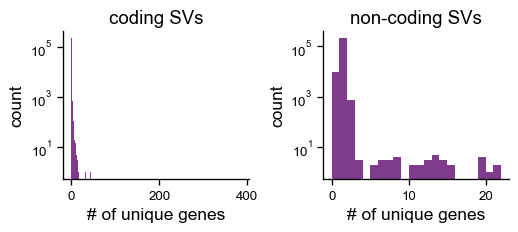

In [67]:
# an svs is True for "multiple-genes-coding" if it affects more than one gene across all coding genic relationships. The same is true for multiple-genes-noncoding.
coding_cols = ['PREDICTED_LOF', 'PREDICTED_PARTIAL_EXON_DUP', 'PREDICTED_INTRAGENIC_EXON_DUP', 'PREDICTED_COPY_GAIN']
noncoding_cols = ['PREDICTED_NEAREST_TSS', 'PREDICTED_INTRONIC', 'PREDICTED_PROMOTER', 'PREDICTED_UTR']

fig, axes = plt.subplots(1, 2, figsize = (6, 2), gridspec_kw = {'wspace': 0.4})
for i, (label, cols) in enumerate(zip(['coding', 'non-coding'], [coding_cols, noncoding_cols])):
    
    # we define all the genes that are "affected" by an SV. We
    # do this by looking at successive genic relationships
    affected_genes = np.array(svs[cols[0]].fillna('').str.split(','))
    for c in cols[1:]:
        affected_genes += np.array(svs[c].fillna('').str.split(','))
        
    # extract out how many unique genes are affected by each SV
    num_unique_affected_genes = [len(set([g for g in g_list if g != ''])) for g_list in affected_genes]
    multiple_genes = np.array(num_unique_affected_genes) > 1
    at_least_one_gene = np.array(num_unique_affected_genes) > 0
    
    # create a plot
    ax = axes[i]
    ax.hist(num_unique_affected_genes, bins = np.arange(max(num_unique_affected_genes) + 1))
    sns.despine(ax = ax)
    ax.set_xlabel('# of unique genes')
    ax.set_ylabel('count')
    ax.set_yscale('log')
    ax.set_title(f'{label} SVs')
    
    # assess numbers here
    print(multiple_genes.sum(), 'out of', at_least_one_gene.sum(), f'{label} SVs that affect at least one gene affect more than one gene')
    
    # add a column to our SVs
    svs[f'multiple-genes-{label}'] = multiple_genes
    
    fig.savefig('images/coding-noncoding-sv-gene-counts.png', bbox_inches = 'tight')

So we can see that some coding SVs affect a huge number of genes. Worth excluding these, probably.

Let's apply this new process to our coding example above.

In [69]:
svs_in_category = nbl_category_svs[(nbl_category_svs['sv_category'] == "coding") & 
                                   (nbl_category_svs["category"] == test_framework)]

# subset the actual SV matrix
svs_in_category_single_gene = svs[(svs["name"].isin(svs_in_category["SV"].tolist())) &
                                  (~svs['multiple-genes-coding'])]

svs_in_category_single_gene.head(2)

,#chrom,start,end,name,svtype,AC,AF,ALGORITHMS,AN,BOTHSIDES_SUPPORT,CHR2,CNV_CONCORDANCE,CPX_INTERVALS,CPX_TYPE,END,END2,EVIDENCE,FAILED_COHORT_COMPARISONS,GENOTYPE_CONCORDANCE,HET_PPV,HET_SENSITIVITY,HG38_REF_PATCH_LOCUS,HIGH_SR_BACKGROUND,HOMVAR_PPV,HOMVAR_SENSITIVITY,MINSL,NCN,NCR,NCR_TMP,NON_REF_GENOTYPE_CONCORDANCE,OLD_ID,PCRMINUS_NCR,PESR_GT_OVERDISPERSION,PREDICTED_BREAKEND_EXONIC,PREDICTED_COPY_GAIN,PREDICTED_DUP_PARTIAL,PREDICTED_INTERGENIC,PREDICTED_INTRAGENIC_EXON_DUP,PREDICTED_INTRONIC,PREDICTED_INV_SPAN,PREDICTED_LOF,PREDICTED_MSV_EXON_OVERLAP,PREDICTED_NEAREST_TSS,PREDICTED_NONCODING_BREAKPOINT,PREDICTED_NONCODING_SPAN,PREDICTED_PARTIAL_EXON_DUP,PREDICTED_PROMOTER,PREDICTED_TSS_DUP,PREDICTED_UTR,SL_MAX,SL_MEAN,SOURCE,STATUS,STRANDS,SVLEN,SVTYPE,TRUTH_AC,TRUTH_AF,TRUTH_AN,TRUTH_VID,UNRESOLVED_TYPE,VAR_PPV,VAR_SENSITIVITY,VAR_SPECIFICITY,N_BI_GENOS,N_HOMREF,N_HET,N_HOMALT,FREQ_HOMREF,FREQ_HET,FREQ_HOMALT,CN_NUMBER,CN_COUNT,CN_FREQ,CN_NONREF_COUNT,CN_NONREF_FREQ,MALE_AN,MALE_AC,MALE_AF,MALE_N_BI_GENOS,MALE_N_HOMREF,MALE_N_HET,MALE_N_HOMALT,MALE_FREQ_HOMREF,MALE_FREQ_HET,MALE_FREQ_HOMALT,MALE_CN_NUMBER,MALE_CN_COUNT,MALE_CN_FREQ,MALE_CN_NONREF_COUNT,MALE_CN_NONREF_FREQ,MALE_N_HEMIREF,MALE_N_HEMIALT,MALE_FREQ_HEMIREF,MALE_FREQ_HEMIALT,FEMALE_AN,FEMALE_AC,FEMALE_AF,FEMALE_N_BI_GENOS,FEMALE_N_HOMREF,FEMALE_N_HET,FEMALE_N_HOMALT,FEMALE_FREQ_HOMREF,FEMALE_FREQ_HET,FEMALE_FREQ_HOMALT,FEMALE_CN_NUMBER,FEMALE_CN_COUNT,FEMALE_CN_FREQ,FEMALE_CN_NONREF_COUNT,FEMALE_CN_NONREF_FREQ,case_control_AFR_AN,case_control_AFR_AC,case_control_AFR_AF,case_control_AFR_N_BI_GENOS,case_control_AFR_N_HOMREF,case_control_AFR_N_HET,case_control_AFR_N_HOMALT,case_control_AFR_FREQ_HOMREF,case_control_AFR_FREQ_HET,case_control_AFR_FREQ_HOMALT,case_control_AFR_CN_NUMBER,case_control_AFR_CN_COUNT,case_control_AFR_CN_FREQ,case_control_AFR_CN_NONREF_COUNT,case_control_AFR_CN_NONREF_FREQ,case_control_AFR_MALE_AN,case_control_AFR_MALE_AC,case_control_AFR_MALE_AF,case_control_AFR_MALE_N_BI_GENOS,case_control_AFR_MALE_N_HOMREF,case_control_AFR_MALE_N_HET,case_control_AFR_MALE_N_HOMALT,case_control_AFR_MALE_FREQ_HOMREF,case_control_AFR_MALE_FREQ_HET,case_control_AFR_MALE_FREQ_HOMALT,case_control_AFR_MALE_CN_NUMBER,case_control_AFR_MALE_CN_COUNT,case_control_AFR_MALE_CN_FREQ,case_control_AFR_MALE_CN_NONREF_COUNT,case_control_AFR_MALE_CN_NONREF_FREQ,case_control_AFR_MALE_N_HEMIREF,case_control_AFR_MALE_N_HEMIALT,case_control_AFR_MALE_FREQ_HEMIREF,case_control_AFR_MALE_FREQ_HEMIALT,case_control_AFR_FEMALE_AN,case_control_AFR_FEMALE_AC,case_control_AFR_FEMALE_AF,case_control_AFR_FEMALE_N_BI_GENOS,case_control_AFR_FEMALE_N_HOMREF,case_control_AFR_FEMALE_N_HET,case_control_AFR_FEMALE_N_HOMALT,case_control_AFR_FEMALE_FREQ_HOMREF,case_control_AFR_FEMALE_FREQ_HET,case_control_AFR_FEMALE_FREQ_HOMALT,case_control_AFR_FEMALE_CN_NUMBER,case_control_AFR_FEMALE_CN_COUNT,case_control_AFR_FEMALE_CN_FREQ,case_control_AFR_FEMALE_CN_NONREF_COUNT,case_control_AFR_FEMALE_CN_NONREF_FREQ,case_control_AMR_AN,case_control_AMR_AC,case_control_AMR_AF,case_control_AMR_N_BI_GENOS,case_control_AMR_N_HOMREF,case_control_AMR_N_HET,case_control_AMR_N_HOMALT,case_control_AMR_FREQ_HOMREF,case_control_AMR_FREQ_HET,case_control_AMR_FREQ_HOMALT,case_control_AMR_CN_NUMBER,case_control_AMR_CN_COUNT,case_control_AMR_CN_FREQ,case_control_AMR_CN_NONREF_COUNT,case_control_AMR_CN_NONREF_FREQ,case_control_AMR_MALE_AN,case_control_AMR_MALE_AC,case_control_AMR_MALE_AF,case_control_AMR_MALE_N_BI_GENOS,case_control_AMR_MALE_N_HOMREF,case_control_AMR_MALE_N_HET,case_control_AMR_MALE_N_HOMALT,case_control_AMR_MALE_FREQ_HOMREF,case_control_AMR_MALE_FREQ_HET,case_control_AMR_MALE_FREQ_HOMALT,case_control_AMR_MALE_CN_NUMBER,case_control_AMR_MALE_CN_COUNT,case_control_AMR_MALE_CN_FREQ,case_control_AMR_MALE_CN_NONREF_COUNT,case_control_AMR_MALE_CN_NONREF_FREQ,case_control_AMR_MALE_N_HEMIREF,case_control_AMR_MALE_N_HEMIALT,case_control_AMR_MALE_FREQ_HEMIREF,case_control_AMR_MALE_FREQ_HEMIALT,case_control_AMR_FEMALE

In [70]:
svs_in_category_single_gene.shape

(3405, 954)

So we can see that we lost around ~400 SVs. Let's see how this affects the result.

In [71]:
svs_in_category_single_gene[genic_relationships].head()

,PREDICTED_LOF,PREDICTED_PARTIAL_EXON_DUP
64,SAMD11,NaN
152,C1QTNF12,NaN
173,CPTP,NaN
308,CFAP74,NaN
322,CFAP74,NaN


We should be a bit more careful if any results turn up positive, but for now we'll just register an SV as contributing to a count for that gene.

In [72]:
nbl_sv_dosages = (
    dosages
    .set_index("ID")
    .loc[svs_in_category_single_gene["name"].tolist(), nbl_cases + nbl_controls]
)
nbl_sv_dosages.head(2)

PT_00QYKRAX  PT_00Y8C0XA  PT_025YMME2  PT_02AE4RSP  \
ID                                                                             
PedSV.2.5.2_DEL_chr1_80           0.0          0.0          0.0          0.0   
PedSV.2.5.2_DEL_chr1_210          0.0          0.0          0.0          0.0   

                          PT_02SNWVRF  PT_06Z51EN5  PT_0CKD259J  PT_0GMP9VVY  \
ID                                                                             
PedSV.2.5.2_DEL_chr1_80           NaN          0.0          0.0          NaN   
PedSV.2.5.2_DEL_chr1_210          0.0          0.0          0.0          0.0   

                          PT_0MVMPZKX  PT_11XN6CG5  PT_1396H6SD  PT_1EQHANKW  \
ID                                                                             
PedSV.2.5.2_DEL_chr1_80           0.0          0.0          0.0          0.0   
PedSV.2.5.2_DEL_chr1_210          0.0          0.0          0.0          0.0   

                          PT_1PA8YT1W  PT_1RH3DTPB  PT_1WETGRS9  PT_1X6CJ589  \
ID                                                                             
PedSV.2.5.2_DEL_chr1_80           0.0          0.0          0.0          0.0   
PedSV.2.5.2_DEL_chr1_210          0.0          0.0          0.0          0.0   

                          PT_1X9YQF9W  PT_21PJ8R0Z  PT_26E4RFYV  PT_2E11C89R  \
ID                                                                             
PedSV.2.5.2_DEL_chr1_80           0.0          0.0          NaN          0.0   
PedSV.2.5.2_DEL_chr1_210          0.0          0.0          0.0          0.0   

                          PT_2HW3QVXZ  PT_2JZNQGTR  PT_2QB9MP9J  PT_2RZN4HR2  \
ID                                                                             
PedSV.2.5.2_DEL_chr1_80           0.0          0.0          0.0          0.0   
PedSV.2.5.2_DEL_chr1_210          0.0          0.0          0.0          0.0   

                          PT_2Y7Q85BM  PT_34XXD32F  PT_397V1YW0  PT_39P91GFA  \
ID                                                                             
PedSV.2.5.2_DEL_chr1_80           0.0          0.0          0.0          0.0   
PedSV.2.5.2_DEL_chr1_210          0.0          0.0          0.0          0.0   

                          PT_39TTDEKT  PT_3E2DBRZY  PT_3TE71Z5R  PT_3VNMNFT6  \
ID                                                                             
PedSV.2.5.2_DEL_chr1_80           0.0          NaN          0.0          0.0   
PedSV.2.5.2_DEL_chr1_210          0.0          0.0          0.0          0.0   

                          PT_4AK1B8JE  PT_4RVXKBFW  PT_4XJZ1KCB  PT_4Y3P2N1P  \
ID                                                                             
PedSV.2.5.2_DEL_chr1_80           0.0          0.0          0.0          0.0   
PedSV.2.5.2_DEL_chr1_210          0.0          0.0          0.0          0.0   

                          PT_534V39HR  PT_56ZM694R  PT_571RCJF0  PT_5BJXQ731  \
ID                                                                             
PedSV.2.5.2_DEL_chr1_80           0.0          0.0          0.0          0.0   
PedSV.2.5.2_DEL_chr1_210          0.0          0.0          0.0          0.0   

                          PT_5CZHK9CR  PT_5E269C8Z  PT_5FCYBT0S  PT_5FR1MCKJ  \
ID                                                                             
PedSV.2.5.2_DEL_chr1_80           NaN          0.0          0.0          0.0   
PedSV.2.5.2_DEL_chr1_210          0.0          0.0          0.0          0.0   

                          PT_5FZDWV2R  PT_5GCSG960  PT_5J8N74BF  PT_5V8MX9JF  \
ID                                                                             
PedSV.2.5.2_DEL_chr1_80           0.0          0.0          NaN          0.0   
PedSV.2.5.2_DEL_chr1_210          0.0          0.0          0.0          0.0   

                          PT_5WAKHYY2  PT_5YZ3J8E7  PT_60H7NA5N  PT_611QXG3Z  \
ID                                                                             
PedSV.2.5.2_DE

In [73]:
nbl_sv_dosages.shape

(3405, 5518)

In [74]:
kept = pd.isnull(nbl_sv_dosages).sum(axis = 0) / len(nbl_sv_dosages) < 0.05

nbl_kept_cases = list(set(nbl_cases) & set(kept[kept].index))
nbl_kept_controls = list(set(nbl_controls) & set(kept[kept].index))

In [75]:
nbl_sv_dosages = nbl_sv_dosages.loc[:, kept]

In [76]:
nbl_sv_dosages.shape

(3405, 5345)

So now we can generate our counts, separately for cases and controls. We can ignore `NaNs`.

In [77]:
sv_counts_cases = nbl_sv_dosages[nbl_kept_cases].fillna(0).sum(axis=1).sort_values()
sv_counts_controls = nbl_sv_dosages[nbl_kept_controls].fillna(0).sum(axis=1).sort_values()
sv_counts_cases.head()

ID
PedSV.2.5.2_DEL_chr1_80       0.0
PedSV.2.5.2_DEL_chr11_9152    0.0
PedSV.2.5.2_DEL_chr11_9214    0.0
PedSV.2.5.2_INV_chr11_23      0.0
PedSV.2.5.2_DEL_chr11_9246    0.0
dtype: float64

In [78]:
sv_counts_cases.sum(), sv_counts_controls.sum()

(380.0, 2177.0)

We can see that the cases have a higher proportion of counts relative to the proportion of samples, which is what we expect (this category is significant).

In [79]:
genes_in_svs = svs_in_category_single_gene[['name'] + genic_relationships].set_index('name')

In [80]:
gene_counts = {'cases': [], 'controls': []}
for cohort, sv_counts in zip(['cases', 'controls'], [sv_counts_cases, sv_counts_controls]):

    sample_genes_in_svs = genes_in_svs.copy()
    sample_genes_in_svs.loc[sv_counts.index, 'count'] = sv_counts.astype(int)

    # simple enough to go through
    cohort_gene_counts = []
    for index, row in sample_genes_in_svs.iterrows():
        if not pd.isnull(row['PREDICTED_LOF']):
            cohort_gene_counts += row['PREDICTED_LOF'].split(',') * row['count']
        if not pd.isnull(row['PREDICTED_PARTIAL_EXON_DUP']):
            cohort_gene_counts += row['PREDICTED_PARTIAL_EXON_DUP'].split(',') * row['count']

    gene_counts[cohort] = pd.DataFrame(np.unique(cohort_gene_counts, return_counts = True), index = ['gene', 'count']).T

In [81]:
gene_counts['cases'].shape, gene_counts['controls'].shape

((354, 2), (1855, 2))

In [82]:
for cohort in ['cases', 'controls']:
    
    cohort_gene_counts = gene_counts[cohort]
    
    genes_in_category_and_gs = cohort_gene_counts[cohort_gene_counts['gene'].isin(g2m_checkpoint)]['count'].sum()
    genes_in_category_and_not_gs = cohort_gene_counts[~cohort_gene_counts['gene'].isin(g2m_checkpoint)]['count'].sum()

    genes_not_in_category_and_in_gs = len(set(g2m_checkpoint) - set(cohort_gene_counts['gene']))
    genes_not_in_category_and_not_gs = len(gene_ref) - genes_not_in_category_and_in_gs
    
    cont_table = np.array([[genes_in_category_and_gs, genes_in_category_and_not_gs], 
                       [genes_not_in_category_and_in_gs, genes_not_in_category_and_not_gs]])
    print(scipy.stats.fisher_exact(cont_table))

(1.0286719437115215, 0.7978015753862095)
(0.9230580608577712, 0.8151448006781976)


So neither cases nor controls are significantly enriched for G2-M checkpoint genes. But at least this process makes sense. Now we can generalize a bit.

In [83]:
hallmark_results = []
for gs, genes in hallmark.items():
    
    genes = [g for g in genes if g in gene_ref]
    
    # store the expected frequency
    expected = f'{len(genes)}/{len(gene_ref)}'
    row = [gs, expected]
    
    for cohort in ['cases', 'controls']:
        
        cohort_gene_counts = gene_counts[cohort]
        
        upper_left = cohort_gene_counts[cohort_gene_counts['gene'].isin(genes)]['count'].sum()
        upper_right = cohort_gene_counts[~cohort_gene_counts['gene'].isin(genes)]['count'].sum()

        bottom_left = len(set(genes) - set(cohort_gene_counts['gene']))
        botttom_right = len(gene_ref) - bottom_left

        cont_table = np.array([[upper_left, upper_right], 
                               [bottom_left, botttom_right]])
        res, p = scipy.stats.fisher_exact(cont_table)

        # provide the expected and the data frequencies
        data = f'{upper_left}/{upper_left + upper_right}'
        row += [res, p, data]
        
    hallmark_results.append(row)
    
col_names = ['gene_set', 'expected', 'case_stat', 'case_p', 'case_data', 'control_stat', 'control_p', 'control_data']
hallmark_results = pd.DataFrame(hallmark_results, columns = col_names)

In [84]:
hallmark_results.query('case_p < 0.05')

,gene_set,expected,case_stat,case_p,case_data,control_stat,control_p,control_data
11,Adipogenesis,200/19201,3.253669,0.000625,12/383,0.816027,0.482276,17/2182
25,mTORC1 Signaling,199/19201,0.000000,0.035958,0/383,0.715413,0.239875,15/2182


So somewhat obviously, it does change the results, although the same gene sets pop out.

## Examine gene "subtraction"

Here, we'll see how the above process is changed when we subtract out genes that are affected in controls. This is a case-focused process.

In [85]:
# only examine genes that have no counts in controls
control_genes = gene_counts['controls']['gene'].tolist()
case_counts = gene_counts['cases'].copy()
case_counts = case_counts[(~case_counts['gene'].isin(control_genes))]
print(case_counts.shape[0], 'out of', gene_counts['cases'].shape[0], 'genes are affected in cases and not controls')

# we must subset our gene set (since genes present in controls cannot be counted)
gene_set_subset = set(g2m_checkpoint) - set(control_genes)

genes_in_category_and_gs = case_counts[case_counts['gene'].isin(gene_set_subset)]['count'].sum()
genes_in_category_and_not_gs = case_counts[~case_counts['gene'].isin(gene_set_subset)]['count'].sum()

genes_not_in_category_and_in_gs = len(set(gene_set_subset) - set(case_counts['gene']))
genes_not_in_category_and_not_gs = len(gene_ref) - len(set(control_genes)) - genes_not_in_category_and_in_gs

cont_table = np.array([[genes_in_category_and_gs, genes_in_category_and_not_gs], 
                   [genes_not_in_category_and_in_gs, genes_not_in_category_and_not_gs]])
print(scipy.stats.fisher_exact(cont_table))

263 out of 354 genes are affected in cases and not controls
(0.6949639705287022, 1.0)


In [86]:
control_genes = gene_counts['controls']['gene'].tolist()
case_counts = gene_counts['cases'].copy()
case_counts = case_counts[(~case_counts['gene'].isin(control_genes))]

hallmark_results = []
for gs, genes in hallmark.items():
    
    # subset our data to remove genes present in controls
    genes = [g for g in genes if g in gene_ref]
    genes = [g for g in genes if g not in control_genes]
    
    # store the expected frequency
    expected = f'{len(genes)}/{len(gene_ref) - len(control_genes)}'
    row = [gs, expected]
    
    top_left = case_counts[case_counts['gene'].isin(genes)]['count'].sum()
    top_right = case_counts[~case_counts['gene'].isin(genes)]['count'].sum()

    bottom_left = len(set(genes) - set(case_counts['gene']))
    bottom_right = len(gene_ref) - len(set(control_genes)) - bottom_left
    
    cont_table = np.array([[top_left, top_right], 
                           [bottom_left, botttom_right]])
    res, p = scipy.stats.fisher_exact(cont_table)
    
    # provide the expected and the data frequencies
    data = f'{top_left}/{top_left + top_right}'
    row += [res, p, data]
        
    hallmark_results.append(row)
    
col_names = ['gene_set', 'expected', 'stat', 'p', 'data']
hallmark_results = pd.DataFrame(hallmark_results, columns = col_names)

In [87]:
hallmark_results.query('p < 0.05')

,gene_set,expected,stat,p,data
11,Adipogenesis,183/17346,4.109195,0.000306,10/278


We see that adipogenesis once again rises. Very interesting!

# Generalized gene set enrichment

Alright, we've been through our examples. Now let's try generalizing across two axes--categories and gene sets. For now, we'll only neuroblastoma significant categories.

I don't know if these `p_values` are already corrected or not. I'll assume they're not.

## Define the categories for analysis

Here, we'll select which categories we want to examine. We'll stick to neuroblastoma, but we'll examine `singleton` and `rare`, as well as `noncoding` and `coding`.

In [88]:
nbl_analysis_categories = nbl_framework_results.query('negative_log10_p_value > 3.5')
nbl_analysis_categories.shape

(77, 22)

Here, we'll also define a helpful lookup that maps from the "collapsed" genic relationships to all their component relationships.

In [89]:
gr_coding_mapping = {'PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP': ['PREDICTED_LOF', 'PREDICTED_PARTIAL_EXON_DUP'],
                     'ANY': ['PREDICTED_COPY_GAIN', 'PREDICTED_INTRAGENIC_EXON_DUP', 'PREDICTED_LOF', 'PREDICTED_PARTIAL_EXON_DUP']}

gr_noncoding_mapping = {'ANY': ['PREDICTED_INTERGENIC', 'PREDICTED_INTRONIC', 'PREDICTED_PROMOTER', 'PREDICTED_UTR']}


## Define the gene sets for analysis

Let's highlight some specific gene sets for analysis. We'll do the following:

* `MSigDB_Hallmark_2020`
* `GO_Biological_Process_2023` (this is the default for GO term analysis)
* `Reactome_2022`

We'll begin with these, and then we can add in other specific ones that might be relevant later:

### GO terms

We're using `gseapy` to get our gene sets. Unfortunately, I've discovered that the gene sets procided by `gp.get_library` _do not_ match the GO gene sets fetched by `biomaRt`. The libraries defined here are from `enrichr`. Maybe they're some custom file or something?

In [90]:
gene_sets = {}
for db_name in ['MSigDB_Hallmark_2020', 'Reactome_2022']:
    db = gp.get_library(name=db_name)
    gene_sets[db_name] = db

The GO terms from `gseapy` are not correct. We have pulled them directly from GO in `pull-go-terms`

In [91]:
go_output = pd.read_csv('data/cwas-results/go-gene-sets/full-go-gene-set.txt', sep ='\t')
go_output.head(2)

,go,label,genes_specific,genes_full,num_genes_panther,level,depth,num_genes_goat
0,GO:0043012,regulation of fusion of sperm to egg plasma me...,NOX5,NOX5,1.0,4.0,6.0,1.0
1,GO:0002728,negative regulation of natural killer cell cyt...,"HLA-F,CD96","HLA-F,CD96",2.0,7.0,11.0,2.0


Add these to our gene sets. We're not going to examine the full GO terms just yet.

In [92]:
gene_sets['GO_Biological_Process_Specific'] = {}

for index, row in go_output.iterrows():
    term = row['go']
    label = row['label'].strip()
    
    if not pd.isnull(row['genes_specific']):
        genes_specific = row['genes_specific'].split(',')
    else:
        genes_specific = []
    
    if not pd.isnull(row['genes_full']):
        genes_full = row['genes_full'].split(',')
    else:
        genes_full = []
        
    gene_sets['GO_Biological_Process_Specific'][label + f' ({term})'] = genes_specific
    # gene_sets['GO_Biological_Process_Full'][label + f' ({term})'] = genes_full
        
    

Below is just some old code to get go terms from the broad (these are basically full)

In [61]:
# link = 'https://data.broadinstitute.org/gsea-msigdb/msigdb/release/2023.2.Hs/c5.go.bp.v2023.2.Hs.symbols.gmt'

# import requests
# from io import StringIO

# go_terms = {}

# resp = requests.get(link).text
# gmt_io = StringIO(resp)
# for line in gmt_io:
#     line = line.strip().split('\t')
#     name = line[0]
#     genes = line[2:]
#     go_terms[name] = genes


And here's some old code to get it from Ensembl

In [62]:
# # fetch the GO ids, and then make them into 50 length chunks
# pattern = r'\((.*?)\)'
# go_id_to_go_term = {re.findall(pattern, g)[0]: g for g in gs['GO_Biological_Process_2023']}
# go_chunks = [list(go_id_to_go_term.keys())[i:i + 50] for i in range(0, len(go_id_to_go_term.keys()), 50)]

# go_results = []
# for i, go_ids in enumerate(go_chunks):
#     print(i, end = ', ')
#     queries ={'go': go_ids}
    
#     # look up the true GO ids from biomart
#     results = bm.query(dataset='hsapiens_gene_ensembl',
#                        attributes=['ensembl_gene_id', 'external_gene_name', 'entrezgene_id', 'go'],
#                        filters=queries)
#     go_results.append(results)
    
# go_results = pd.concat(go_results)
# go_results['go_term'] = go_results['go'].replace(go_id_to_go_term)
# go_results[['go_term', 'external_gene_name']].to_csv('ref/GO_Biological_Process_Gene_Mapping.csv', index=False)

# go_terms = pd.read_csv('ref/GO_Biological_Process_Gene_Mapping.csv').set_index('go_term')
# go_terms.head(2)

# new_go = {}
# for gs, genes in gene_sets['GO_Biological_Process_2023'].items():
#     if gs in go_terms.index:
#         correct_genes = go_terms.loc[gs]
#         new_go[gs] = correct_genes
        
# gene_sets['GO_Biological_Process_2023'] = new_go

In [63]:
adrenal_genes = pd.read_csv('ref/adrenal-specific-genes.txt', sep='\t', comment = '#')['Gene Name'].tolist()
adrenal_genes = [g for g in adrenal_genes if g in gene_ref]

gene_sets['custom'] = {'adrenal-specific-exp': adrenal_genes}

In [64]:
len(gene_sets['GO_Biological_Process_Specific'])

12558

In [65]:
gene_ref_set = set(gene_ref)

In [66]:
gs_count = 0
for db_name, db in gene_sets.items():
    print(db_name, len(db.values()))
    gs_count += len(db.values())
    
    # ensure that all genes are in our gene reference
    for gs, genes in db.items():
        gene_sets[db_name][gs] = list(set(genes) & gene_ref_set)

gs_count

MSigDB_Hallmark_2020 50
Reactome_2022 1816
GO_Biological_Process_Specific 12558
custom 1


14425

Clearly that's going to lead to some false positives, but it is what it is. We'll export for convenience.

In [67]:
with open('ref/gene-sets.txt', 'w') as out:
    for db_name, db in gene_sets.items():
        for gs, genes in db.items():
            row = [db_name, gs] + genes
            row = ','.join(row)
            out.write(row + '\n')

In [68]:
row

'custom,adrenal-specific-exp,CHGB,SOAT1,KCNK2,RET,PHOX2A,CARTPT,FDX1,CYP11B2,STAR,MCOLN3,VWA5B2,MC2R,PHOX2B,CYP17A1,MGARP,AS3MT,CYP11B1,UCP1,CHRNA3,FAM43B,HSD3B2,PNMT,TH,CYP21A2,DBH,SLC18A1,DRGX,ARHGAP36,AKR1B1,MAP3K15'

## Run the thing

This code will need to be decently adaptable, since it has to handle a few different unique components (noncoding categories, etc) and analyses. We're going to store _many_ different components, so let's list them all out here. For each gene set and category, we need to do the following:

1. Calculate the significance of case overlap and significance of control overlap
2. Calculate the significance of cases after subtracting control genes
3. Denote the specific genic overlaps, the SVs involved, etc. 

And then we need to repeat that for the SVs that don't affect more than one gene. This is a _ton_ of data to keep track of. We should be systematic about how we store everything.

I'd also like to do one more thing--we get the sense that many of these coding categories are overlapping. I'd like to know if we include all the coding SVs together, whether something comes out of it.

In [69]:
nbl_category_svs.head(2)

,SV,chrom,start,end,category,sv_category
0,PedSV.2.5.2_DUP_chr1_794,chr1,19221626,19301822,DUP.RARE.PREDICTED_COPY_GAIN.lof_constrained.e...,coding
1,PedSV.2.5.2_DUP_chr1_1379,chr1,44731601,44792024,DUP.RARE.PREDICTED_COPY_GAIN.lof_constrained.e...,coding


In [70]:
# Define a new category that includes SVs from all significant coding categories
included_categories = nbl_analysis_categories.query('sv_category == "coding"')['category_name'].tolist()
umbrella_category_svs = nbl_category_svs[nbl_category_svs['category'].isin(included_categories)].copy()
umbrella_category_svs['category'] = 'ANY.ANY.ANY.SIGNIFICIANT_CODING_UMBRELLA'

# drop duplicate SVs
umbrella_category_svs = umbrella_category_svs.drop_duplicates(subset = ['SV'])

if 'ANY.ANY.ANY.SIGNIFICIANT_CODING_UMBRELLA' not in nbl_category_svs['category'].tolist():
    nbl_category_svs = pd.concat([nbl_category_svs, umbrella_category_svs]).reset_index(drop = True)
    
# add this new category to our analysis set
new_row = {'category_name': 'ANY.ANY.ANY.SIGNIFICIANT_CODING_UMBRELLA', 'sv_type': 'ANY', 
           'frequency': 'SINGLETON,RARE', 'sv_category': 'coding',
           'af_category': 'singleton,rare'}
new_row_series = pd.Series(new_row, index=nbl_analysis_categories.columns)

if 'ANY.ANY.ANY.SIGNIFICIANT_CODING_UMBRELLA' not in nbl_analysis_categories['category_name'].tolist():
    nbl_analysis_categories = nbl_analysis_categories.append(new_row_series, ignore_index=True)


In [71]:
gse_results = []
gene_lists = {}

for i, (index, row) in enumerate(nbl_analysis_categories.iterrows()):
    print(i, end = ', ')
    cat_name = row['category_name']
    af_category = row['af_category']
    sv_category = row['sv_category']
    p_category = row['p_value']
    
    cat_components = cat_name.split('.')
    
    base_row = [cat_name, af_category, sv_category, p_category]
    
    # here, we define the necessary genic relationships
    # we handle the collapsed categories as well
    if sv_category == 'coding':
        gr = cat_components[2]

        # convert gr to components
        genic_rel = gr_coding_mapping.get(gr, [gr])
        
    elif sv_category == 'non-coding':
        gr = cat_components[4]

        # convert gr to components
        genic_rel = gr_noncoding_mapping.get(gr, [gr])
        
    # swap out intergenic for nearest_tss
    if 'PREDICTED_INTERGENIC' in genic_rel:
        genic_rel[genic_rel.index('PREDICTED_INTERGENIC')] = 'PREDICTED_NEAREST_TSS'
        
    # next, we pull out our SVs in this category
    svs_in_category = nbl_category_svs[(nbl_category_svs['sv_category'] == sv_category) & 
                                       (nbl_category_svs["category"] == cat_name)]
    
    # we're going to store which genes are included in the analyses
    gene_lists[cat_name] = {'multiple': {}, 'single': {}}
        
    #################################
    ### SINGLE VS. MULTI GENE SVS ###
    #################################
    
    # This is our first branch point - whether we are considering SVs that affect a single gene
    # or including SVs that can affect multiple.
    for sv_incl_strat in ['multiple', 'single']:
        
        base_row_strat = base_row + [sv_incl_strat]
    
        # subset the actual SV matrix
        svs_in_category_strat = svs[svs["name"].isin(svs_in_category["SV"].tolist())]
        
        # further subset if only examining SVs that affect a single gene
        if sv_incl_strat == 'single':
            svs_in_category_strat = svs_in_category_strat[~svs_in_category_strat[f'multiple-genes-{sv_category}']]
    
        # extract the dosages for cases and controls
        nbl_sv_dosages = (
            dosages
            .set_index("ID")
            .loc[svs_in_category_strat["name"].tolist(), nbl_cases + nbl_controls]
            )
    
        # drop samples with bad GT rates
        kept = pd.isnull(nbl_sv_dosages).sum(axis = 0) / len(nbl_sv_dosages) < 0.05
        nbl_kept_cases = list(set(nbl_cases) & set(kept[kept].index))
        nbl_kept_controls = list(set(nbl_controls) & set(kept[kept].index))
    
        nbl_sv_dosages = nbl_sv_dosages.loc[:, kept]
    
        # define the number of unique SVs
        sv_counts_cases = nbl_sv_dosages[nbl_kept_cases].fillna(0).sum(axis=1).sort_values()
        sv_counts_controls = nbl_sv_dosages[nbl_kept_controls].fillna(0).sum(axis=1).sort_values()
    
        # define our affected genes
        genes_in_svs = svs_in_category_strat[['name'] + genic_rel].set_index('name')
    
        # for each gene, count up the number of SVs in cases and controls, separately.
        gene_counts = {'cases': [], 'controls': []}
        for cohort, sv_counts in zip(['cases', 'controls'], [sv_counts_cases, sv_counts_controls]):

            sample_genes_in_svs = genes_in_svs.copy()
            sample_genes_in_svs.loc[sv_counts.index, 'count'] = sv_counts.astype(int)

            # count for each genic relationship
            cohort_gene_counts = []
            for index, row in sample_genes_in_svs.iterrows():
                for col in genic_rel:
                    if not pd.isnull(row[col]):
                        cohort_gene_counts += row[col].split(',') * row['count']

            gene_counts[cohort] = pd.DataFrame(np.unique(cohort_gene_counts, return_counts = True), index = ['gene', 'count']).T

            # store the number of unique SVs for cases and controls
            base_row_strat.append(len(gene_counts[cohort]))
            
            # and store the actual genes themselves
            gene_lists[cat_name][sv_incl_strat][cohort] = gene_counts[cohort]
        
        ##########################
        ### FISHERS EXACT TEST ###
        ##########################
        
        # Here is our second branch point - whether control genes are included or not.
        control_genes = set(gene_counts['controls']['gene'])
        
        # identify genes that are case unique
        case_counts = gene_counts['cases'].copy()
        gene_counts['case-unique'] = case_counts[(~case_counts['gene'].isin(control_genes))]
        
        gene_lists[cat_name][sv_incl_strat]['case-unique'] = gene_counts['case-unique']
        
        for db_name, db in gene_sets.items():
            for gs_name, gs_genes in db.items():
                
                row = base_row_strat + [db_name, gs_name]

                for cohort in ['cases', 'controls', 'case-unique']:
                    
                    cohort_gene_counts = gene_counts[cohort]
                    gs_genes_sub = gs_genes.copy()
                    gene_ref_sub = gene_ref.copy()
                    
                    # subset our data if control genes aren't included
                    if cohort == 'case-unique':
                        gs_genes_sub = list(set(gs_genes_sub) - control_genes)
                        gene_ref_sub = list(set(gene_ref_sub) - control_genes)
                    
                    if cohort in ['cases', 'case-unique']:
                        expected = f'{len(gs_genes_sub)}/{len(gene_ref_sub)}'
                        row += [expected]
                        
                    num_unique_overlaps = len(set(cohort_gene_counts['gene']) & set(gs_genes_sub))

                    top_left = cohort_gene_counts[cohort_gene_counts['gene'].isin(gs_genes_sub)]['count'].sum()
                    top_right = cohort_gene_counts[~cohort_gene_counts['gene'].isin(gs_genes_sub)]['count'].sum()

                    bottom_left = len(set(gs_genes_sub) - set(cohort_gene_counts['gene']))
                    bottom_right = len(gene_ref_sub) - bottom_left

                    cont_table = np.array([[top_left, top_right], 
                                           [bottom_left, bottom_right]])
                    res, p = scipy.stats.fisher_exact(cont_table)

                    # calculate the number of unique overlaps. Helps us determine
                    # if signal is being driven by a single/few gene(s)
                    data = f'{top_left}/{top_right + top_left}'

                    # store our data
                    row = row + [res, p, num_unique_overlaps, data]

                gse_results.append(row)
            
names = ['category', 'af_category', 'sv_category', 'category_p', 'sv_incl_strat', 'num_genes_cases', 'num_genes_controls',
         'db', 'gs', 'expected', 
         'res_cases', 'p_cases', 'num_unique_gene_overlaps_cases', 'data_cases',
         'res_controls', 'p_controls', 'num_unique_gene_overlaps_controls', 'data_controls',
         'expected_unique', 
         'res_cases_unique', 'p_cases_unique', 'num_unique_gene_overlaps_cases_unique', 'data_cases_unique']

gse_results = pd.DataFrame(gse_results, columns = names)

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 

In [72]:
gene_lists_total = []
for category, storage in gene_lists.items():
    for strat, data in storage.items():
        for cohort, counts in data.items():
            storage_counts = counts.copy()
            storage_counts['cohort'] = cohort
            storage_counts['sv_incl_strat'] = strat
            storage_counts['category'] = category
            gene_lists_total.append(storage_counts)
            
gene_lists_total = pd.concat(gene_lists_total)

In [85]:
gene_lists_total.to_csv('data/cwas-results/gene-set-enrichment-analysis-counts.csv', index = False)

In [86]:
gse_results.to_csv('data/cwas-results/cwas-gene-set-enrichment-results.csv', index=False)

This notebook is getting much too large, so I'm going to analyze these results in a different notebook.